# Местоположение магазина
*__Цель проекта: найти оптимальное место для супермаркета низкой ценовой категории в Москве__*

In [1]:
import requests
import pandas as pd
import numpy as np
import geocoder
from geopy.geocoders import Nominatim
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
from sklearn.metrics import silhouette_score

### Выгрузка данных

Прочитаем файл со средним доходом жителей районов Москвы

In [2]:
df_income = pd.read_csv('mean_income.csv', names = ['year','neighbourhood','income'], header=None)
df_income

,year,neighbourhood,income
0,2012,Академический,106878.000000
1,2012,Алексеевский,58914.800000
2,2012,Алтуфьевский,48239.600000
3,2012,Арбат,73728.500000
4,2012,Аэропорт,74378.800000
...,...,...,...
871,2017,Южное Тушино,73835.014326
872,2017,Южнопортовый,79492.023111
873,2017,Якиманка,165957.910212
874,2017,Ярославский,70761.851332


Видим, что доход есть за разные года. Оставим только 1, самый актуальный

In [3]:
df_income.year.max()

2017

In [4]:
df_income = df_income[df_income['year']==2017]
df_income

,year,neighbourhood,income
730,2017,Академический,172064.682212
731,2017,Алексеевский,80886.907735
732,2017,Алтуфьевский,65083.466255
733,2017,Арбат,133191.308156
734,2017,Аэропорт,112833.967428
...,...,...,...
871,2017,Южное Тушино,73835.014326
872,2017,Южнопортовый,79492.023111
873,2017,Якиманка,165957.910212
874,2017,Ярославский,70761.851332


Получим координаты районов

In [5]:
def get_coordinates(row):
    lat_lng_coords = None

    while(lat_lng_coords is None):
      g = geocoder.arcgis(f'{row["neighbourhood"]}, Moscow')
      lat_lng_coords = g.latlng

    return pd.Series([lat_lng_coords[0], lat_lng_coords[1]])

In [6]:
df_income[['latitude','longitude']] = df_income.apply(get_coordinates, axis=1)
df_income.head()

C:\Users\Dom\AppData\Local\Temp\ipykernel_6136\2620577532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_income[['latitude','longitude']] = df_income.apply(get_coordinates, axis=1)
C:\Users\Dom\AppData\Local\Temp\ipykernel_6136\2620577532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_income[['latitude','longitude']] = df_income.apply(get_coordinates, axis=1)


,year,neighbourhood,income,latitude,longitude
730,2017,Академический,172064.682212,55.686631,37.573767
731,2017,Алексеевский,80886.907735,55.813200,37.646248
732,2017,Алтуфьевский,65083.466255,55.880038,37.585899
733,2017,Арбат,133191.308156,55.748564,37.582157
734,2017,Аэропорт,112833.967428,55.801982,37.532214


Проверим, что у нас нет нулевых значений

In [7]:
df_income.isnull().sum()

year             0
neighbourhood    0
income           0
latitude         0
longitude        0
dtype: int64

Поле года нам уже не нужно

In [8]:
df_income = df_income.drop('year', axis=1)
df_income.shape

(146, 4)

Получим координаты Москвы

In [31]:
address = 'Moscow, Russia'
geolocator = Nominatim(user_agent="Moscow_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(f'Географические координаты Москвы: {latitude}, {longitude}')

Географические координаты Москвы: 55.7505412, 37.6174782


Координаты определены верно. Используем их для отрисовки районов на карте

In [63]:
map = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(df_income['latitude'], df_income['longitude'], df_income['neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)

map

Получим данные о заведениях в районах через Foursquare API. За радиус возьмём 2000 м

In [3]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):

        url = 'https://api.foursquare.com/v3/places/search?client_id={}&client_secret={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            lat,
            lng,
            radius,
            LIMIT)

        headers = {
            "accept": "application/json",
            "Authorization": API_key
        }
        
        results = requests.get(url, headers=headers).json()['results']

        venues_list.append([(
            name,
            lat,
            lng,
            v['name'],
            v['geocodes']['main']['latitude'],
            v['geocodes']['main']['longitude'],
            v['categories'][0]['name']) for v in results if v['categories'] and v['geocodes']])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood',
                  'Neighbourhood Latitude',
                  'Neighbourhood Longitude',
                  'Venue',
                  'Venue Latitude',
                  'Venue Longitude',
                  'Venue Category']

    return(nearby_venues)

In [6]:
venues = getNearbyVenues(names=df_income['neighbourhood'],
                                   latitudes=df_income['latitude'],
                                   longitudes=df_income['longitude'])

print(venues.shape)
venues.head()

(5176, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Академический,55.686631,37.573767,Billy McDaniel,55.687993,37.571479,Pub
1,Академический,55.686631,37.573767,Вкусвилл,55.684944,37.570512,Health Food Store
2,Академический,55.686631,37.573767,Lюstra Bar,55.689895,37.575576,Cocktail Bar
3,Академический,55.686631,37.573767,Бинооптика,55.683126,37.570074,Optometrist
4,Академический,55.686631,37.573767,Самсон-Фарма,55.682887,37.569336,Pharmacy


In [8]:
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

onehot['Neighbourhood'] = venues['Neighbourhood']

fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

print(f'Size: {onehot.shape}')
onehot.head()

Size: (5176, 347)


,Neighbourhood,Adult Store,Agriculture and Forestry Service,American Restaurant,Amusement Park,Aquarium,Arcade,Argentinian Restaurant,Armenian Restaurant,Art Gallery,...,Watch Store,Water Park,Waterfall,Waterfront,Wholesaler,Wine Bar,Wine Store,Wings Joint,Women's Store,Zoo
0,Академический,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Академический,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Академический,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Академический,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Академический,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Находим частоту категорий заведений в каждом районе

In [9]:
moscow_grouped = onehot.groupby('Neighbourhood').mean().reset_index()
print(f'Размер: {moscow_grouped.shape}')
moscow_grouped.head()

Размер: (146, 347)


,Neighbourhood,Adult Store,Agriculture and Forestry Service,American Restaurant,Amusement Park,Aquarium,Arcade,Argentinian Restaurant,Armenian Restaurant,Art Gallery,...,Watch Store,Water Park,Waterfall,Waterfront,Wholesaler,Wine Bar,Wine Store,Wings Joint,Women's Store,Zoo
0,Академический,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.02,...,0.0,0.0,0.0,0.0,0.0,0.00,0.04,0.0,0.0,0.0
1,Алексеевский,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0
2,Алтуфьевский,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0
3,Арбат,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.00,0.02,0.0,0.0,0.0
4,Аэропорт,0.0,0.0,0.0,0.0,0.02,0.02,0.0,0.0,0.02,...,0.0,0.0,0.0,0.0,0.0,0.02,0.02,0.0,0.0,0.0


### Кластеризация районов

Нам нужно выделить жилые районы. Посмотрим на самые частые заведения в районах

In [10]:
def most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]

In [11]:
num_top_venues = 10

columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    columns.append('{} Most Common Venue'.format(ind+1))

neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = moscow_grouped['Neighbourhood']

for ind in np.arange(moscow_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = most_common_venues(moscow_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1 Most Common Venue,2 Most Common Venue,3 Most Common Venue,4 Most Common Venue,5 Most Common Venue,6 Most Common Venue,7 Most Common Venue,8 Most Common Venue,9 Most Common Venue,10 Most Common Venue
0,Академический,Coffee Shop,Café,Butcher,Park,Escape Room,Wine Store,Gourmet Store,Health Food Store,Retail,Italian Restaurant
1,Алексеевский,Monument,Café,Convenience Store,Bakery,Science Museum,Park,Pet Supplies Store,Beer Store,Theater,Snack Place
2,Алтуфьевский,Grocery Store,Pet Supplies Store,Park,Dining and Drinking,Driving School,Beer Bar,Butcher,Drugstore,Hookah Bar,Pizzeria
3,Арбат,Coffee Shop,Café,Plaza,Monument,Seafood Restaurant,Bar,Russian Restaurant,Movie Theater,Museum,Moroccan Restaurant
4,Аэропорт,Park,Sporting Goods Retail,Coffee Shop,Beer Bar,Bakery,Language School,Movie Theater,Sports and Recreation,Department Store,Grocery Store


Определим оптимальное количество кластеров

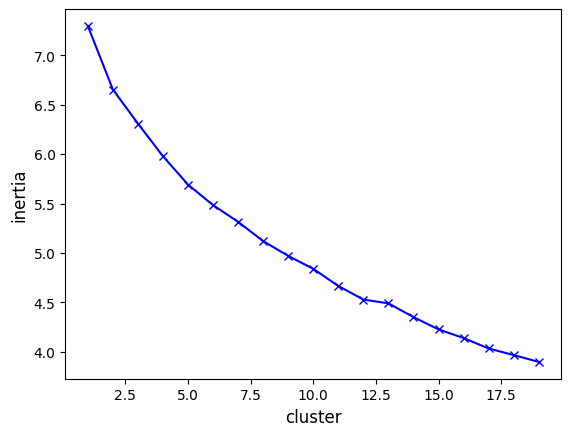

In [15]:
moscow_grouped_clustering = moscow_grouped.drop('Neighbourhood', axis=1)
sum_of_squared_distances = []
K = range(1,20)

def get_inertia(cluster_num, X):
    k_means =  KMeans(n_clusters=cluster_num, random_state=42, n_init=20)
    k_means.fit(X)
    inertia = k_means.inertia_
    return inertia

inertia = []
for cluster_num in range(1, 20):
    inertia.append(get_inertia(cluster_num, moscow_grouped_clustering))

plt.xlabel("cluster", fontsize=12)
plt.ylabel("inertia", fontsize=12)
plt.plot([i for i in range(1, 20)], inertia, 'xb-') 

Из графика нужное количество кластеров не очевидно. Воспользуемся методом силуэта

<Axes: xlabel='cluster', ylabel='silhouette'>

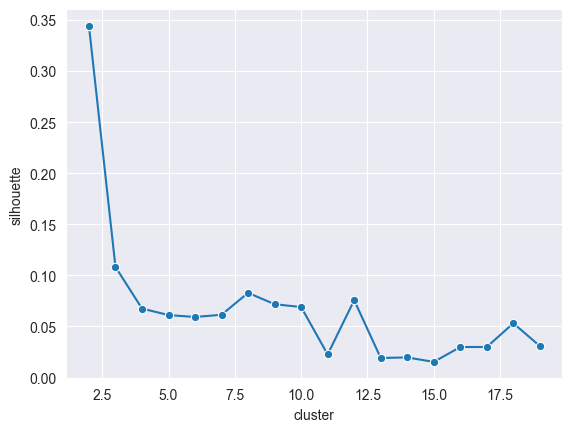

In [16]:
def get_silhouette(cluster_num, X):
    k_means =  KMeans(n_clusters=cluster_num, init='k-means++', n_init=20, random_state=42)
    k_means.fit(X)
    silhouette = silhouette_score(X, k_means.predict(X))
    return silhouette

silhouette_res = {"silhouette": [], "cluster": []}

for cluster_num in range(2, 20):
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, moscow_grouped_clustering))
    silhouette_res["cluster"].append(cluster_num)
    
silhouette_df = pd.DataFrame(silhouette_res)

sns.set_style("darkgrid")
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")

График достигает максимума на 2 кластерах, но в этом случае кластеры могут быть слишком крупные. Поэтому возьмём 12 кластеров - на этой отметке график силуэта тоже достигает высокого значения, при этом на графике метода локтя там заметен изгиб

In [64]:
kclusters = 12

kmeans = KMeans(n_clusters=kclusters, random_state=100).fit(moscow_grouped_clustering)

c:\Users\Dom\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Сформурируем датафрейм с районами, кластерами и категориями заведений

In [27]:
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

moscow_merged = df_income.merge(neighbourhoods_venues_sorted.set_index('Neighbourhood'), left_on='neighbourhood', right_on='Neighbourhood')

moscow_merged.head()

,neighbourhood,income,latitude,longitude,Cluster Labels,1 Most Common Venue,2 Most Common Venue,3 Most Common Venue,4 Most Common Venue,5 Most Common Venue,6 Most Common Venue,7 Most Common Venue,8 Most Common Venue,9 Most Common Venue,10 Most Common Venue
0,Академический,172064.682212,55.686631,37.573767,0,Coffee Shop,Café,Butcher,Park,Escape Room,Wine Store,Gourmet Store,Health Food Store,Retail,Italian Restaurant
1,Алексеевский,80886.907735,55.813200,37.646248,0,Monument,Café,Convenience Store,Bakery,Science Museum,Park,Pet Supplies Store,Beer Store,Theater,Snack Place
2,Алтуфьевский,65083.466255,55.880038,37.585899,3,Grocery Store,Pet Supplies Store,Park,Dining and Drinking,Driving School,Beer Bar,Butcher,Drugstore,Hookah Bar,Pizzeria
3,Арбат,133191.308156,55.748564,37.582157,0,Coffee Shop,Café,Plaza,Monument,Seafood Restaurant,Bar,Russian Restaurant,Movie Theater,Museum,Moroccan Restaurant
4,Аэропорт,112833.967428,55.801982,37.532214,10,Park,Sporting Goods Retail,Coffee Shop,Beer Bar,Bakery,Language School,Movie Theater,Sports and Recreation,Department Store,Grocery Store


In [28]:
moscow_merged['Cluster Labels'].value_counts()

Cluster Labels
10    48
3     32
0     30
1     19
2      7
9      2
7      2
8      2
11     1
5      1
4      1
6      1
Name: count, dtype: int64

Визуализируем кластеры

In [32]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, area, cluster in zip(moscow_merged['latitude'], moscow_merged['longitude'], moscow_merged['neighbourhood'], moscow_merged['Cluster Labels']):
    label = folium.Popup(str(area) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

Возьмём 4 самых больших кластера и посмотрим 5 самых частых категорий заведений там

__Кластер 0__

In [33]:
moscow_merged.loc[moscow_merged['Cluster Labels'] == 0, moscow_merged.columns[5:15]].apply(pd.value_counts).sum(axis=1).sort_values(ascending = False)[:5]

Coffee Shop    26.0
Café           21.0
Park           20.0
Monument       11.0
Bar            10.0
dtype: float64

__Кластер 1__

In [34]:
moscow_merged.loc[moscow_merged['Cluster Labels'] == 1, moscow_merged.columns[5:15]].apply(pd.value_counts).sum(axis=1).sort_values(ascending = False)[:5]

Park                 19.0
Grocery Store        12.0
Health Food Store    11.0
Movie Theater         5.0
Café                  5.0
dtype: float64

__Кластер 3__

In [35]:
moscow_merged.loc[moscow_merged['Cluster Labels'] == 3, moscow_merged.columns[5:15]].apply(pd.value_counts).sum(axis=1).sort_values(ascending = False)[:5]

Grocery Store    31.0
Retail           21.0
Park             19.0
Butcher          10.0
Playground       10.0
dtype: float64

__Кластер 10__

In [36]:
moscow_merged.loc[moscow_merged['Cluster Labels'] == 10, moscow_merged.columns[5:15]].apply(pd.value_counts).sum(axis=1).sort_values(ascending = False)[:5]

Park                 43.0
Coffee Shop          25.0
Grocery Store        21.0
Health Food Store    20.0
Café                 20.0
dtype: float64

Больше всего похож на жилой кластер 3: среди самых частых заведений там есть продуктовые магазины, пекарни, парки и детские площадки и нет кафе. Плюс на карте выше видно, что эти районы находятся на окраинах

### Выгрузка и обработка данных по жилым районам

Выделим жилые районы

In [39]:
df_residential = df_income[df_income['neighbourhood'].isin(moscow_merged.loc[moscow_merged['Cluster Labels'] == 1, 'neighbourhood'])]

In [40]:
df_residential

,neighbourhood,income,latitude,longitude
5,Бабушкинский,66785.322331,55.869234,37.665926
9,Бибирево,56865.269794,55.883330,37.600000
13,Братеево,56381.150646,55.637550,37.764380
52,Лосиноостровский,57582.207902,55.880542,37.695884
53,Люблино,58599.675620,55.677380,37.760050
76,Отрадное,69602.264727,55.861247,37.603067
79,Печатники,75896.293829,55.692525,37.728594
80,Покровское-Стрешнево,71910.135754,55.825337,37.432439
88,поселение Краснопахорское,72661.500000,55.430964,37.276241
89,поселение Марушкинское,56318.600000,55.595787,37.208060


Посчитаем супермаркеты в наших жилых районах

In [42]:
#ID супермаркетов в Foursquare API
supermarket_category = '52f2ab2ebcbc57f1066b8b46'

def getMarketVenues(row, radius=2000):

    url = 'https://api.foursquare.com/v3/places/search?client_id={}&client_secret={}&ll={},{}&categories={}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        row['latitude'],
        row['longitude'],
        supermarket_category,
        radius,
        LIMIT)
    
    headers = {
            "accept": "application/json",
            "Authorization": API_key
        }
    
    count = len(requests.get(url, headers=headers).json()["results"])

    return pd.Series(count)

In [43]:
df_residential['supermarkets'] = df_residential.apply(getMarketVenues, axis=1)

C:\Users\Dom\AppData\Local\Temp\ipykernel_4948\397222724.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_residential['supermarkets'] = df_residential.apply(getMarketVenues, axis=1)


In [44]:
df_residential

,neighbourhood,income,latitude,longitude,supermarkets
5,Бабушкинский,66785.322331,55.869234,37.665926,2
9,Бибирево,56865.269794,55.883330,37.600000,1
13,Братеево,56381.150646,55.637550,37.764380,4
52,Лосиноостровский,57582.207902,55.880542,37.695884,3
53,Люблино,58599.675620,55.677380,37.760050,1
76,Отрадное,69602.264727,55.861247,37.603067,2
79,Печатники,75896.293829,55.692525,37.728594,0
80,Покровское-Стрешнево,71910.135754,55.825337,37.432439,2
88,поселение Краснопахорское,72661.500000,55.430964,37.276241,0
89,поселение Марушкинское,56318.600000,55.595787,37.208060,0


Выгоднее всего будет открыть супермаркет там, где других супермаркетов нет, поэтому выделим районы с числом супермаркетов 0

In [45]:
df_residential = df_residential[df_residential['supermarkets']==0]

Спарсим из Википедии данные о плотности населения районов

In [65]:
density = pd.read_html('https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D0%B9%D0%BE%D0%BD%D1%8B_%D0%B8_%D0%BF%D0%BE%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F_%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D1%8B')[0]
density

,№,Флаг,Герб,Название района[2]/ поселения[3][4],Название cоответствующего внутригородского муниципального образования: муниципального округа / поселения / городского округа[5],Адми- нистра- тивный округ,"Пло- щадь, [6][7] км²","Насе- ление 2024[8], чел.","Плот- ность насе- ления 2024, чел. / км²","Пло- щадь жилого фонда (01.01. 2010)[9], тыс. м²","Жил- площадь на чело- века (01.01. 2010), м²/чел."
0,1,NaN,NaN,Академический,Академический,ЮЗАО,583,↗114 228,19593.14,24670.0,227.0
1,2,NaN,NaN,Алексеевский,Алексеевский,СВАО,529,↘77 681,14684.50,16079.0,205.0
2,3,NaN,NaN,Алтуфьевский,Алтуфьевский,СВАО,325,↘55 741,17151.08,8393.0,155.0
3,4,NaN,NaN,Арбат,Арбат,ЦАО,211,↗36 246,17178.20,7310.0,260.0
4,5,NaN,NaN,Аэропорт,Аэропорт,САО,458,↘81 833,17867.47,19397.0,259.0
...,...,...,...,...,...,...,...,...,...,...,...
141,142,NaN,NaN,"Сосенское, поселение[Прим. 17]","Сосенское, поселение",НАО,6707,↗122 303,1823.51,NaN,NaN
142,143,NaN,NaN,"Троицк, поселение[Прим. 18]","Троицк, городской округ",ТАО,1633,↗65 043,3983.04,NaN,NaN
143,144,NaN,NaN,"Филимонковское, поселение[Прим. 19]","Филимонковское, поселение",НАО,3577,↗17 811,497.93,NaN,NaN
144,145,NaN,NaN,"Щаповское, поселение[Прим. 20]","Щаповское, поселение",ТАО,8606,↗13 360,155.24,NaN,NaN


Объединим эти данные с нашей таблицей и проверим, есть ли нулевые значения плотности

In [47]:
df_residential_new = df_residential.merge(density[['Название района[2]/ поселения[3][4]', 'Плот- ность насе- ления 2024, чел. / км²']], how='left', left_on='neighbourhood', right_on='Название района[2]/ поселения[3][4]')
print(df_residential_new.shape)
df_residential_new.isnull().sum()

(7, 7)


neighbourhood                               0
income                                      0
latitude                                    0
longitude                                   0
supermarkets                                0
Название района[2]/ поселения[3][4]         4
Плот- ность насе- ления 2024, чел. / км²    4
dtype: int64

In [49]:
df_residential_new = df_residential_new.drop('Название района[2]/ поселения[3][4]', axis = 1)

In [52]:
df_residential_new = df_residential_new.rename({'Плот- ность насе- ления 2024, чел. / км²': 'density'}, axis = 1)
df_residential_new

,neighbourhood,income,latitude,longitude,supermarkets,density
0,Печатники,75896.293829,55.692525,37.728594,0,5005.25
1,поселение Краснопахорское,72661.500000,55.430964,37.276241,0,NaN
2,поселение Марушкинское,56318.600000,55.595787,37.208060,0,NaN
3,поселение Новофёдоровское,48250.900000,55.464701,36.942421,0,NaN
4,поселение Сосенское,108689.800000,55.569451,37.480051,0,NaN
5,Северное Тушино,67246.896271,55.861780,37.424930,0,18303.72
6,Щукино,83412.481680,55.800000,37.450000,0,14367.49


Вручную заполним нулевые значения плотности, которые не получилось присоединить по названию района

In [59]:
df_residential_new.loc[df_residential_new['neighbourhood'] == 'поселение Краснопахорское', 'density'] = 148.43
df_residential_new.loc[df_residential_new['neighbourhood'] == 'поселение Марушкинское', 'density'] = 320.56
df_residential_new.loc[df_residential_new['neighbourhood'] == 'поселение Новофёдоровское', 'density'] = 147.92
df_residential_new.loc[df_residential_new['neighbourhood'] == 'поселение Сосенское', 'density'] = 1823.51

Посмотрим, в каких районах самая высокая плотность населения и самые низкие доходы

In [61]:
df_residential_new.sort_values(by='density', ascending = False)

,neighbourhood,income,latitude,longitude,supermarkets,density
5,Северное Тушино,67246.896271,55.861780,37.424930,0,18303.72
6,Щукино,83412.481680,55.800000,37.450000,0,14367.49
0,Печатники,75896.293829,55.692525,37.728594,0,5005.25
4,поселение Сосенское,108689.800000,55.569451,37.480051,0,1823.51
2,поселение Марушкинское,56318.600000,55.595787,37.208060,0,320.56
1,поселение Краснопахорское,72661.500000,55.430964,37.276241,0,148.43
3,поселение Новофёдоровское,48250.900000,55.464701,36.942421,0,147.92


In [62]:
df_residential_new.sort_values(by='income')

,neighbourhood,income,latitude,longitude,supermarkets,density
3,поселение Новофёдоровское,48250.900000,55.464701,36.942421,0,147.92
2,поселение Марушкинское,56318.600000,55.595787,37.208060,0,320.56
5,Северное Тушино,67246.896271,55.861780,37.424930,0,18303.72
1,поселение Краснопахорское,72661.500000,55.430964,37.276241,0,148.43
0,Печатники,75896.293829,55.692525,37.728594,0,5005.25
6,Щукино,83412.481680,55.800000,37.450000,0,14367.49
4,поселение Сосенское,108689.800000,55.569451,37.480051,0,1823.51


**Мы видим, что самая высокая плотность населения в Северном Тушино, при этом средний доход там один из самых низких в нашей выборке. Поэтому можно сделать вывод, что супермаркет низкой ценовой категории лучше открыть там**